In [7]:
import os
os.chdir('..')
import torch
import torch.nn as nn
import glob
from dataset import Dataset_SMP, get_validation_augmentation, get_preprocessing, display_result, get_training_augmentation
import segmentation_models_pytorch as smp
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from bisenet import BiSeNet

In [8]:
torch.backends.cudnn.deterministic = True
random.seed(123456)
torch.manual_seed(123456)
torch.cuda.manual_seed(123456)
np.random.seed(123456)

In [9]:
def denormalize(image, preprocessing_fn):
    image = image * torch.tensor(preprocessing_fn.keywords['std']).view(-1,1,1) + torch.tensor(preprocessing_fn.keywords['mean']).view(-1,1,1)
    return image

# model

In [10]:
input_size = 448
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
model = smp.Unet(encoder_name="mobilenet_v2",  encoder_weights='imagenet', activation='sigmoid') # Activation=None because I apply activation layer myself
model.segmentation_head[0] = nn.Conv2d(16, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
file_path  = 'C:\\Users\\gueganj\\Desktop\\Face_Parsing\\face parsing - PyTorch\\res\\cp\\79999_iter.pth'
#model = BiSeNet(n_classes=19) # trained on 19 classes
#model.load_state_dict(torch.load(file_path, map_location=device))
#model.conv_out.conv_out = nn.Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
preprocessing_fn = smp.encoders.get_preprocessing_fn("mobilenet_v2", 'imagenet')

In [12]:
model

Unet(
  (encoder): MobileNetV2Encoder(
    (features): Sequential(
      (0): ConvBNReLU(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): ConvBNReLU(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): ConvBNReLU(
            (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=Fals

# checkpoint

In [6]:
checkpoint = torch.load('C:\\Users\\gueganj\\Desktop\\Eyeglasses Detection\\checkpoint_logs\\23_10_2020-16_42.ckpt')
model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

# data

In [7]:
data_root = "C:\\Users\\gueganj\\Desktop\\My_DataBase\\nature"
folder_data = glob.glob(os.path.join(data_root,"images\\*.jpg"))
folder_mask = glob.glob(os.path.join(data_root,"masks\\*.jpg"))
test_image_paths = folder_data[-10:]
test_mask_paths  = folder_mask[-10:]
# create DataLoader
test_dataset = Dataset_SMP(test_image_paths, test_mask_paths, augmentation=get_validation_augmentation(input_size,input_size), preprocessing=get_preprocessing(preprocessing_fn))
test_loader  = torch.utils.data.DataLoader(test_dataset)

# evaluate

In [8]:
threshold  = 0.5 
metrics    = [smp.utils.metrics.IoU(threshold=threshold), smp.utils.metrics.Recall(threshold=threshold), smp.utils.metrics.Precision(threshold=threshold)]
loss       = smp.utils.losses.DiceLoss()

In [9]:
test_epoch = smp.utils.train.ValidEpoch(model=model, loss=loss, metrics=metrics, device=device)
logs       = test_epoch.run(test_loader)

valid: 100%|█| 10/10 [00:03<00:00,  3.31it/s, dice_loss - 0.7391, iou_score - 0.1555, recall - 0.4791, precision - 0.30


# display

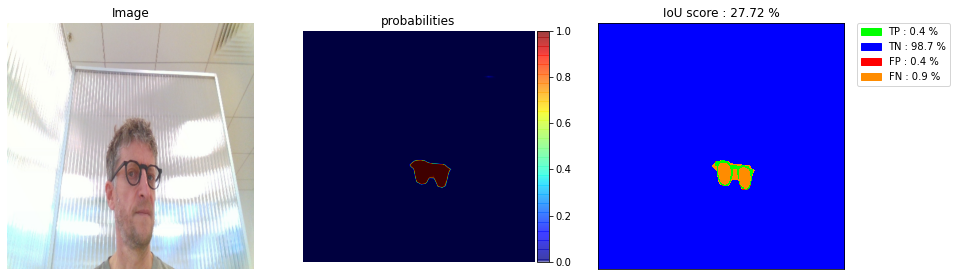

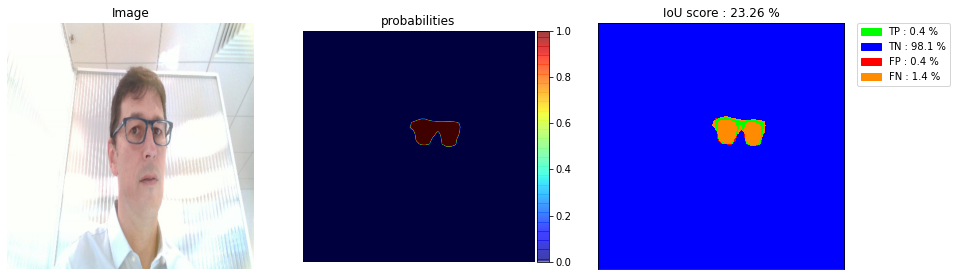

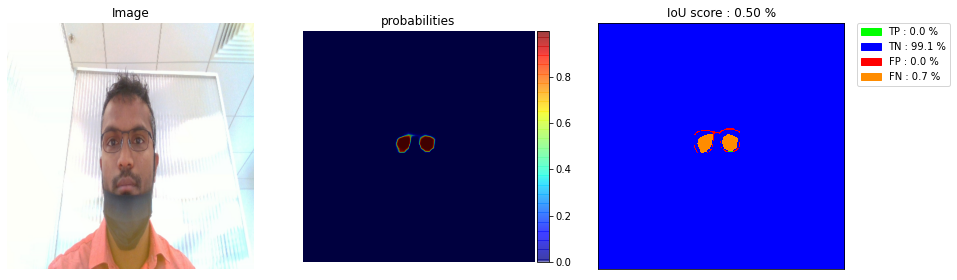

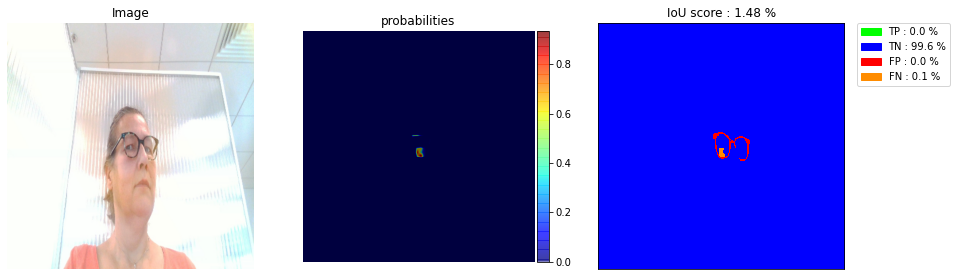

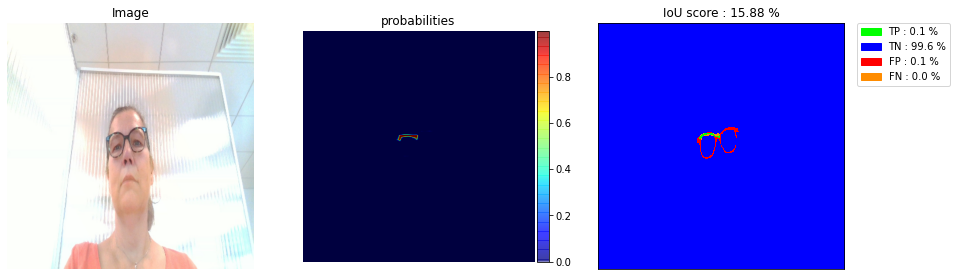

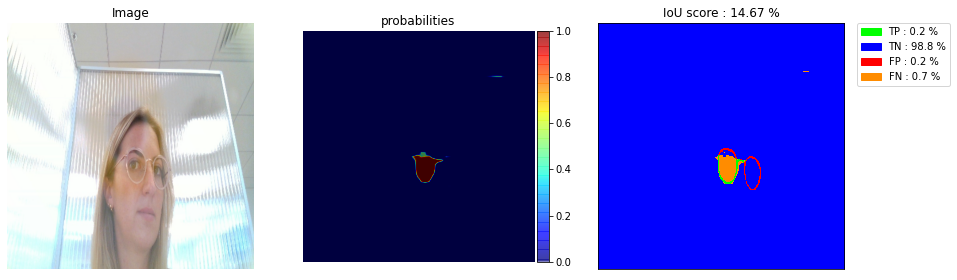

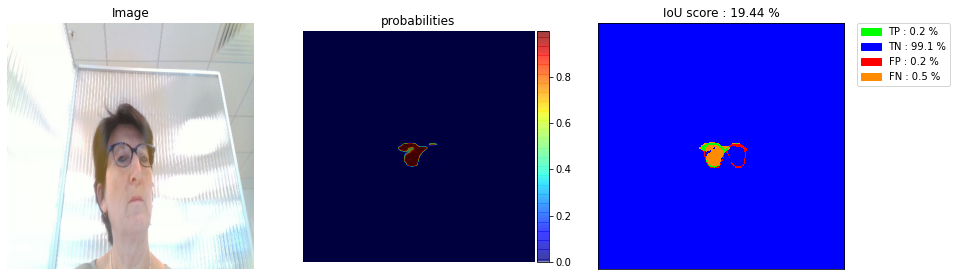

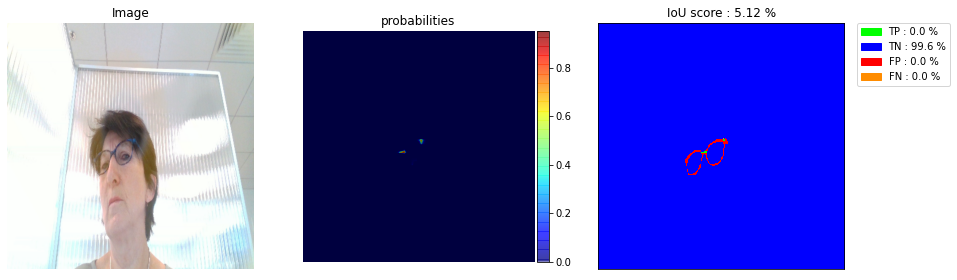

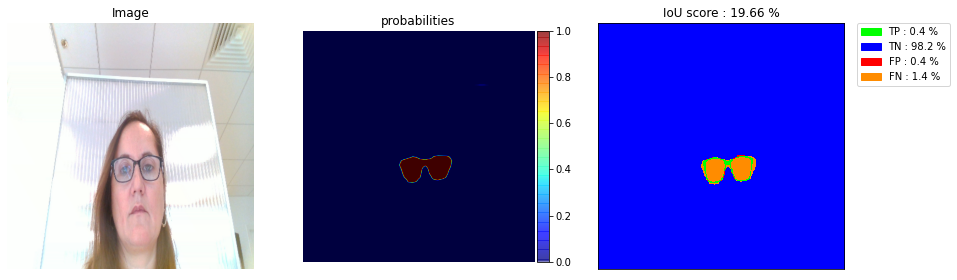

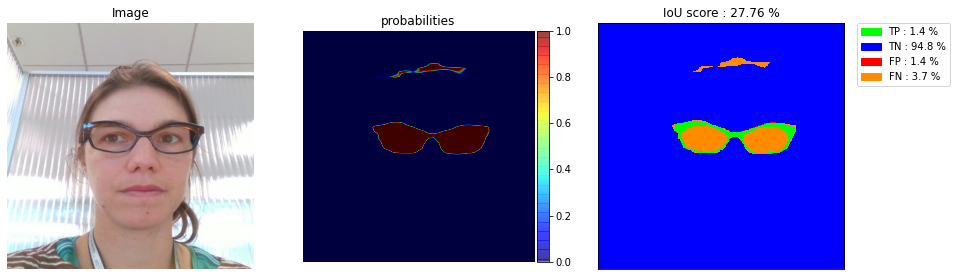

In [10]:
for image, mask in test_loader:
    with torch.no_grad():
        proba = model.forward(image)
    image = denormalize(image.squeeze(0), preprocessing_fn)
    # display
    display_result(image.permute(1,2,0).numpy(), mask, proba.squeeze(), threshold, metrics[0], display=True)

# Bad Prediction

In [11]:
ind = random.sample(range(0, len(folder_data)), 100)
list_image = [folder_data[i] for i in ind]
list_mask  = [folder_mask[i] for i in ind]
dataset = Dataset_SMP(list_image, list_mask, augmentation=get_validation_augmentation(input_size,input_size), preprocessing=get_preprocessing(preprocessing_fn))
loader  = torch.utils.data.DataLoader(dataset)

ValueError: Sample larger than population or is negative

In [ ]:
metric = smp.utils.metrics.IoU(threshold=threshold)

In [ ]:
x     = []
prob  = []
msk   = []
score = []
for image, mask in tqdm(loader):
    with torch.no_grad():
        proba = model.forward(image)
        prob.append(proba)
        score.append(metric(proba, mask))
        x.append(image)
        msk.append(mask)

In [ ]:
index = np.argsort(score)

In [ ]:
for i in index:
    img = denormalize(x[i].squeeze(0), preprocessing_fn)
    display_result(img.permute(1,2,0).numpy(), msk[i].squeeze(), prob[i].squeeze(), threshold, metric, display=True)

In [ ]:
img = denormalize(image.squeeze(0), preprocessing_fn)
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.imshow(img.squeeze().permute(1,2,0).numpy())
plt.subplot(122)
plt.imshow(mask.squeeze())
plt.show()

In [ ]:
indices = np.where(mask.squeeze() == 1)

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(mask.squeeze())
plt.plot(indices[1][-1],indices[0][-1],'ro')
plt.show()